# Домашнее задание 4. Конструирование текстовых признаков из твитов пользователей

## Сбор данных

Первый этап - сбор твитов пользователей. Необходимо подключаться к Twitter API и запрашивать твиты по id пользователя. 
Подключение к API подробно описано в ДЗ 1.

In [34]:
import time
import twitter
import string
import re
import os
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import numpy as np
import pandas as pd
from collections import defaultdict
import json
from sklearn.feature_extraction import DictVectorizer
from wordcloud import WordCloud, STOPWORDS # for plotting a cloud
import matplotlib.pyplot as plt

%matplotlib inline

In [35]:
CONSUMER_KEY = "PTNcJUZmk5w75LEQsSraCuKo1"
CONSUMER_SECRET = "1NoB3ANMKEDrlabb5C1b3oBdminESRsTrgfKR6dAjhOHPx4oyo"

ACCESS_TOKEN_KEY = "703693954907299840-hhW6FX4nmKnECqsLT4CP7v9EG6rE8FA"
ACCESS_TOKEN_SECRET = "sIQ9JTCnCxfUvBd2pwFvpTbERExLHkmJPGcch4hiPv7Km"

api = twitter.Api(consumer_key=CONSUMER_KEY, 
                  consumer_secret=CONSUMER_SECRET, 
                  access_token_key=ACCESS_TOKEN_KEY, 
                  access_token_secret=ACCESS_TOKEN_SECRET)

Для получения твитов пользователя может быть использован метод GetUserTimeline из библиотеки python-twitter. Он позволяет получить не более 200 твитов пользователя. По каждому пользователю достаточно собрать 200 твитов.

Метод имеет ограничение по количеству запросов в секунду. Для получения информации о промежутке времени, которое необходимо подождать для повторного обращения к API может быть использован метод `GetSleepTime`. Для получения информации об ограничениях запросов с помощью метода `GetUserTimeLine` необходимо вызывать `GetSleepTime` с параметром "statuses/user_timeline".

Метод GetUserTimeline возвращает объекты типа Status. У этих объектов есть метод AsDict, который позволяет представить твит в виде словаря.

Id пользователей необходимо считать из файла, как было сделано в ДЗ 1.

Необходимо реализовать функцию `get_user_tweets(user_id)`. Входной параметр - id пользователя из файла. Возвращаемое значение - массив твитов пользователя, где каждый твит представлен в виде словаря. Предполагается, что информация о пользователе содержится в твитах, которые пользователь написал сам. Это означает, что можно попробовать отфильтровать ответы другим пользователям, ссылки и ретвиты, а так же картинки и видео, так как наша цель - найти текстовую информацию.

In [36]:
def get_user_tweets(user_id):
    """returns list of tweets as dicts"""
    while True:
        try:
            delay = api.GetSleepTime("statuses/user_timeline")
            if delay > 0:
                print 'delay...'
                time.sleep(delay)
            try:    
                statuses = api.GetUserTimeline(user_id, count = 200, include_rts = False, exclude_replies = True, trim_user=True)
                for tweet in statuses:
                    tweet.text = re.sub(r'(?:\@|https?\://)\S+', '', tweet.text)
                    tweet.text = re.sub(r'[^\w]', ' ', tweet.text)
                return [tweet.AsDict() for tweet in statuses if 'media' not in tweet.AsDict().keys()]
            except:
                return [{'user':{'id':user_id}}]
        except twitter.TwitterError:
            print 'delay....'
            time.sleep(3*60)
            continue

In [ ]:
print (get_user_tweets(30005269))[0]

## Разбор текста твита

Обработка текста предполагает разбиение текста на отдельные элементы - параграфы, предложения, слова. Мы будем преобразовывать текст твита к словам. Для этого текст необходимо разбить на слова. Сделать это можно, например, с помощью регулярного выражения.

Необходимо реализовать функцию, `get_words(text)`. Входной параметр - строка с текстом. Возвращаемое значение - массив строк (слов). Обратите внимание, что нужно учесть возможное наличие пунктуации и выделить по возможности только слова. 

In [37]:
def get_words(text):
    """returns list of words"""
    return [word.strip(string.punctuation) for word in text.split()]

In [ ]:
print get_words("Here are different words: one, two, three!")

Далее полученные слова необходимо привести к нормальной форме. То есть привести их к форме единственного числа настоящего времени и пр. Сделать это можно с помощью библиотеки nltk. Информацию по загрузке, установке библиотеки и примерах использования можно найти на сайте http://www.nltk.org/

Для загрузки всех необходимых словарей можно воспользоваться методом download из библиотеки nltk.

Для дальнейшей обработки слова должны быть приведены к нижнему регистру. 

Для приведения к нормальной форме можно использовать `WordNetLemmatizer` из библиотеки nltk. У этого класса есть метод `lemmatize`.

Также необходимо убрать из текста так называемые стоп-слова. Это часто используемые слова, не несущие смысловой нагрузки для наших задач. Сделать это можно с помощью `stopwords` из nltk.corpus

Необходимо реализовать функцию `get_tokens(words)`. Входной параметр - массив слов. Возвращаемое значение - массив токенов.

In [38]:
def get_tokens(words):
    """returns list of tokens"""
    wnl = WordNetLemmatizer()
    return [wnl.lemmatize(word.lower(), 'v') for word in words if word not in stopwords.words('english')]

In [ ]:
print get_tokens(["tested", "function", "and", "using", "a", "lot", "of", "Different", "words"])

Необходимо реализовать функцию `get_tweet_tokens(tweet)`. Входной параметр - текст твита. Возвращаемое значение -- токены твита. 

In [39]:
def get_tweet_tokens(tweet):
    words = get_words(tweet)
    return get_tokens(words) 

In [ ]:
get_tweet_tokens((get_user_tweets(758669826))[0]['text'])

Необходимо реализовать функцию `collect_users_tokens()`. Функция должна сконструировать матрицу признаков пользователей. В этой матрице строка - пользователь. Столбец - токен. На пересечении - сколько раз токен встречается у пользователя.
Для построения матрицы можно использовать `DictVectorizer` из `sklearn.feature_extraction`.

In [52]:
def collect_users_tokens(df_users):
    """returns users list and list of user dicts. Each dict contains frequence of user tokens"""
    
    users_tokens = []
    users = df_users['uid']
    not_processed_users = []
    for user in users:
        if user not in processed_users:
            not_processed_users.append(user)
            
#    print 'users =', len(users)
#    print 'processed_users =', len(processed_users)
#    print 'not_processed_users =', len(not_processed_users)
    
    print 'start' 
    for i, user in enumerate(not_processed_users):
        tweets_array = get_user_tweets(user)
        if user in user_records.keys():
            user_records[user] += tweets_array
        else:
            user_records[user] = tweets_array
        if i % 100 == 0:
            print 'doing...'
        for tweet in tweets_array:
            json.dump(tweet, f)
            f.write('\n')
    print 'finish'
    i = 0
    for user, tweets in user_records.iteritems():
        user_dict = {}
        for tweet in tweets:
            try:
                tweet_tokens = get_tweet_tokens(tweet['text'])
            except Exception as ex:
                tweet_tokens = []
            for token in tweet_tokens:
                if token in user_dict.keys():
                    user_dict[token] += tweet_tokens.count(token)
                else:
                    user_dict[token] = tweet_tokens.count(token)
        
        if len(user_dict.keys()) > 0:         
            users_tokens += [user_dict]
        else:
            users = users[users != user]
            
    return list(users), users_tokens


In [53]:
TRAINING_SET_URL = "twitter_train.txt"
EXAMPLE_SET_URL = "twitter_example.txt"
df_users_train = pd.read_csv(TRAINING_SET_URL, sep=",", header=0, names=["uid", "cat"])
df_users_ex = pd.read_csv(EXAMPLE_SET_URL, sep=",", header=0, names=["uid", "cat"])
df_users_ex['cat'] = None
df_users = pd.concat([df_users_train, df_users_ex])

user_records = {}
tmp_file_name = 'tmp_user_records'
i = 0
if os.path.exists(tmp_file_name):
    with open(tmp_file_name) as f:
        for line in f:
            try:
                rec = (json.loads(line))
                uid = rec['user']['id']
                if uid in user_records.keys():
                    user_records[uid] += [rec]
                else:
                    user_records[uid] = [rec]
            except:
                continue

processed_users = set()
for r in user_records.keys():
    try:
        processed_users.add(r)
    except:
        print r
        
f = open(tmp_file_name, 'a')

users, users_tokens = collect_users_tokens(df_users)
print 'func end'
v = DictVectorizer()
vs = v.fit_transform(users_tokens)

users = 6898
processed_users = 4024
not_processed_users = 2874
start
doing...
finish
func end
3970


In [54]:
np.savez("out_4.dat", data=vs, users=users, users_tokens=users_tokens )

Далее для получения представления о полученной информацию о токенах предлагается отобразить ее в виде облака тэгов. [Подсказка](http://anokhin.github.io/img/tag_cloud.png). 

In [42]:
def draw_tag_cloud(v, vs):
    """Draws tag cloud of found tokens"""

    plt.rcParams['figure.figsize'] = (20.0, 20.0)
    vs_array = np.sum(vs.toarray(), axis=0)

    wordcloud = WordCloud (
         stopwords=set(list(STOPWORDS) + list(stopwords.words('english'))),
         background_color='black',
         width=1800,
         height=1400,
         max_words=750
    )
    
    wordcloud.fit_words(zip(v.get_feature_names(), vs_array))

    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    return

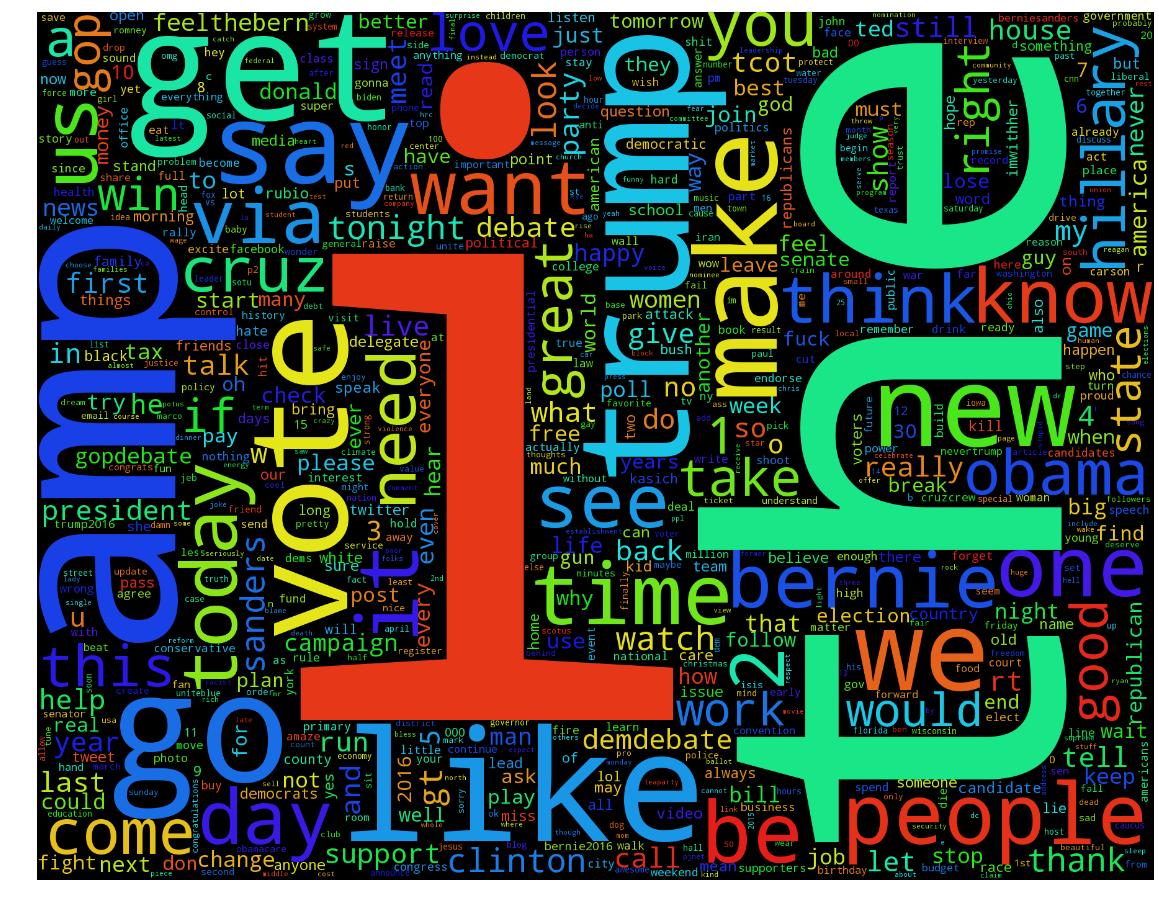

In [55]:
draw_tag_cloud(v, vs)